In [19]:
import torch
import torch.nn as nn
# We don't strictly need torchdiffeq for the JIT solver,
# but we keep it for legacy compatibility if needed.
# !pip install torchdiffeq
from torchdiffeq import odeint
import cantera as ct
import numpy as np
import pandas as pd
import json
import os
import time
import matplotlib.pyplot as plt

# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Mount your Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [43]:
# --- File Paths ---
# Adjust this path to where your files actually are
DRIVE_PATH = "/content/drive/MyDrive/SciML_Project"

MODEL_SAVE_PATH = os.path.join(DRIVE_PATH, 'chem_node_net_3lay_128dim.pth')
PARAMS_FILE = os.path.join(DRIVE_PATH, 'normalization_params.json')
MECHANISM_FILE = os.path.join(DRIVE_PATH, 'AmmoniaH2_react_mech_stagni2018.yaml')

# --- Model & Data Parameters ---
HIDDEN_DIMS = 128
SIM_END_TIME = 0.30

# --- Test Parameters ---
TEST_CASES = [
    (1250.0, 0.7),
    (1350.0, 1.2),
    (1450.0, 0.95)]

# --- Set device ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [35]:
class ChemNet(nn.Module):
    def __init__(self, input_features, hidden_features):
        super(ChemNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_features, hidden_features),
            nn.ELU(),
            nn.Linear(hidden_features, hidden_features),
            # nn.ELU(),
            # nn.Linear(hidden_features, hidden_features),
            # nn.ELU(),
            # nn.Linear(hidden_features, hidden_features), # 4th layer
            nn.ELU(),
            nn.Linear(hidden_features, input_features)
        )

    def forward(self, t, y):
        return self.net(y)

In [36]:
# Helper Functions (Fixed)

def get_ground_truth_sim(T0, phi, P, n_points=500):
    """Runs a 0D Cantera simulation."""
    gas = ct.Solution(MECHANISM_FILE)
    gas.TP = T0, P
    gas.set_equivalence_ratio(phi, 'NH3', {'O2': 1.0, 'N2': 3.76})

    # Fix: Added energy='on' and explicitly suppressed the clone warning if needed
    # Note: If 'clone' kwarg errors on your version, remove it.
    r = ct.IdealGasConstPressureReactor(gas)

    sim = ct.ReactorNet([r])

    time_points = np.linspace(0.0, SIM_END_TIME, n_points)
    states = np.zeros((n_points, gas.n_species + 1))

    for i, t in enumerate(time_points):
        sim.advance(t)
        states[i, :-1] = r.Y
        states[i, -1] = r.T

    columns = gas.species_names + ['Temperature (K)']
    df = pd.DataFrame(states, columns=columns)
    df.insert(0, 'Time (s)', time_points)
    return df

def calculate_ignition_delay(df):
    """
    Calculates ignition delay using max dT/dt.
    """
    df_sorted = df.sort_values(by='Time (s)')
    time_arr = df_sorted['Time (s)'].values
    temp_arr = df_sorted['Temperature (K)'].values

    if len(time_arr) < 2:
        return np.nan

    # Calculate derivative
    dT_dt = np.gradient(temp_arr, time_arr)
    # Find index of max derivative
    ign_index = np.argmax(dT_dt)

    return time_arr[ign_index]

In [37]:
# 1. Load Params
with open(PARAMS_FILE, 'r') as f:
    norm_params = json.load(f)

feature_names = list(norm_params['mins'].keys())
N_FEATURES = len(feature_names)

mins_array = np.array([norm_params['mins'][col] for col in feature_names])
maxs_array = np.array([norm_params['maxs'][col] for col in feature_names])
epsilon = 1e-12

def normalize(data_np):
    return (data_np - mins_array) / (maxs_array - mins_array + epsilon)

def denormalize(data_np):
    return (data_np * (maxs_array - mins_array + epsilon)) + mins_array

# 2. Load Base Model
derivative_net = ChemNet(N_FEATURES, HIDDEN_DIMS).to(device)
derivative_net.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=device))
derivative_net.eval()
print("Base model loaded.")

Base model loaded.


In [38]:
# JIT Compiler Setup

# 1. Define JIT-compatible Network with Embedded Solver
class ChemNetJIT(nn.Module):
    def __init__(self, input_features, hidden_features):
        super(ChemNetJIT, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_features, hidden_features),
            nn.ELU(),
            nn.Linear(hidden_features, hidden_features),
            nn.ELU(),
            # nn.Linear(hidden_features, hidden_features),
            # nn.ELU(),
            # nn.Linear(hidden_features, hidden_features),
            # nn.ELU(),
            nn.Linear(hidden_features, input_features)
        )

    def forward(self, y: torch.Tensor) -> torch.Tensor:
        return self.net(y)

    # --- THE FIX IS HERE: @torch.jit.export ---
    @torch.jit.export
    def rk4_step(self, y: torch.Tensor, dt: float) -> torch.Tensor:
        k1 = self.forward(y)
        k2 = self.forward(y + 0.5 * dt * k1)
        k3 = self.forward(y + 0.5 * dt * k2)
        k4 = self.forward(y + dt * k3)
        return y + (dt / 6.0) * (k1 + 2*k2 + 2*k3 + k4)

    @torch.jit.export
    def integrate(self, y0: torch.Tensor, t_end: float, dt: float) -> torch.Tensor:
        n_steps = int(t_end / dt)
        y_current = y0
        # Loop entirely in C++ (when scripted)
        for i in range(n_steps):
            y_current = self.rk4_step(y_current, dt)
        return y_current

# 2. Transfer weights
jit_net = ChemNetJIT(N_FEATURES, HIDDEN_DIMS).to(device)
jit_net.load_state_dict(derivative_net.state_dict())
jit_net.eval()

# 3. Script the ENTIRE model (Network + Solver)
# This compiles everything into a single optimized binary
jit_net = torch.jit.script(jit_net)

print("JIT Compiler ready. Solver exported successfully.")

JIT Compiler ready. Solver exported successfully.


In [39]:
# Prediction Wrapper

def get_node_prediction(T0, phi, P, n_points=500):
    """
    Wrapper to get a full trajectory dataframe for plotting.
    Uses the JIT model methods.
    """
    # Setup Initial Condition
    gas = ct.Solution(MECHANISM_FILE)
    gas.TP = T0, P
    gas.set_equivalence_ratio(phi, 'NH3', {'O2': 1.0, 'N2': 3.76})

    y0_phys = np.array([gas.Y[gas.species_index(col)] if col != 'Temperature (K)' else gas.T for col in feature_names])
    y0_norm = normalize(y0_phys)
    y0_tensor = torch.tensor(y0_norm, dtype=torch.float32).to(device)

    # Integration for Plotting
    t_eval = np.linspace(0.0, SIM_END_TIME, n_points)
    dt = t_eval[1] - t_eval[0]

    trajectory = []
    y_curr = y0_tensor

    with torch.no_grad():
        for _ in range(n_points):
            trajectory.append(y_curr.cpu().numpy())
            # Call the exported method
            y_curr = jit_net.rk4_step(y_curr, dt)

    trajectory = np.array(trajectory)
    pred_phys = denormalize(trajectory)

    df = pd.DataFrame(pred_phys, columns=feature_names)
    df.insert(0, 'Time (s)', t_eval)
    return df

--- Generating Plots ---


/tmp/ipython-input-3498158023.py:11: DeprecationWarning: ReactorBase.__init__: After Cantera 3.2, the default value of the `clone` argument will be `True`, resulting in an independent copy of the `phase` being created for use by this reactor. Add the `clone=False` argument to retain the old behavior of sharing `Solution` objects.
  r = ct.IdealGasConstPressureReactor(gas)
/tmp/ipython-input-3088252154.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(species_to_plot))


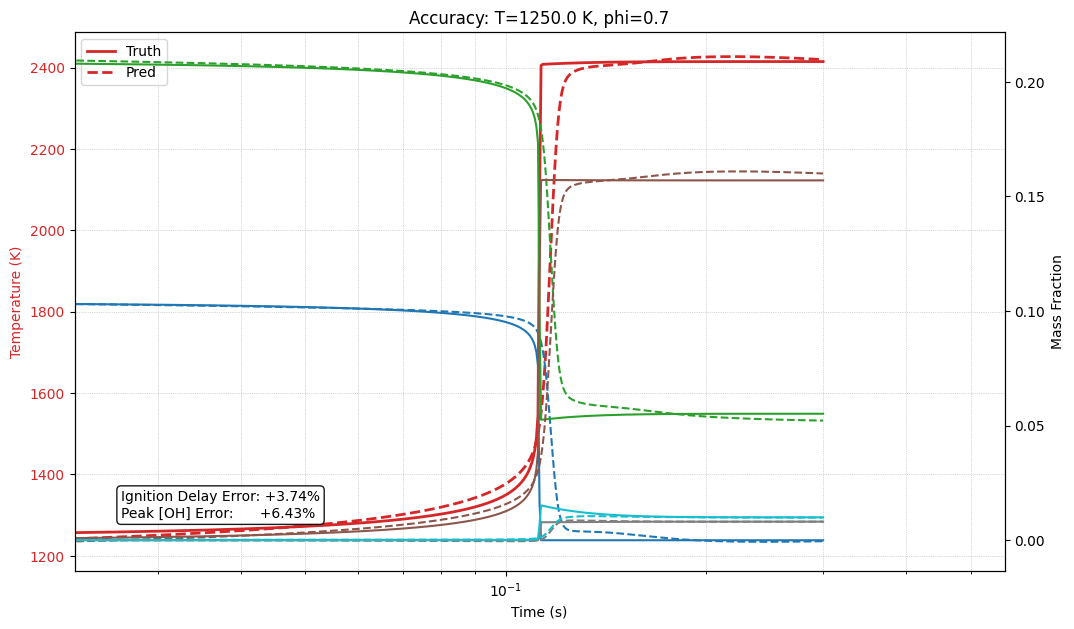

/tmp/ipython-input-3498158023.py:11: DeprecationWarning: ReactorBase.__init__: After Cantera 3.2, the default value of the `clone` argument will be `True`, resulting in an independent copy of the `phase` being created for use by this reactor. Add the `clone=False` argument to retain the old behavior of sharing `Solution` objects.
  r = ct.IdealGasConstPressureReactor(gas)
/tmp/ipython-input-3088252154.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(species_to_plot))


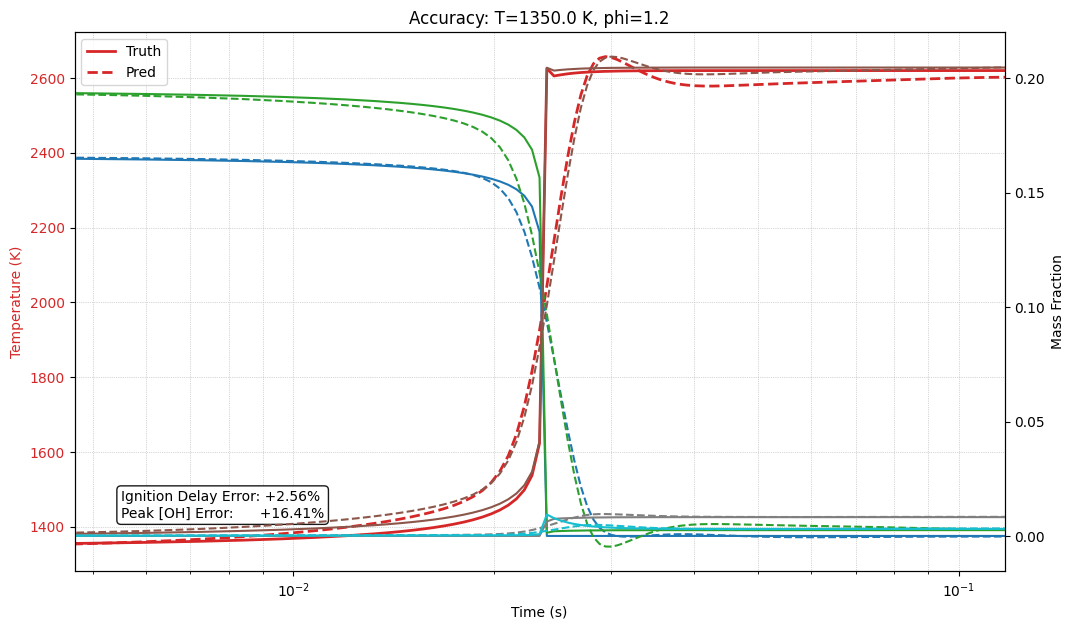

/tmp/ipython-input-3498158023.py:11: DeprecationWarning: ReactorBase.__init__: After Cantera 3.2, the default value of the `clone` argument will be `True`, resulting in an independent copy of the `phase` being created for use by this reactor. Add the `clone=False` argument to retain the old behavior of sharing `Solution` objects.
  r = ct.IdealGasConstPressureReactor(gas)
/tmp/ipython-input-3088252154.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(species_to_plot))


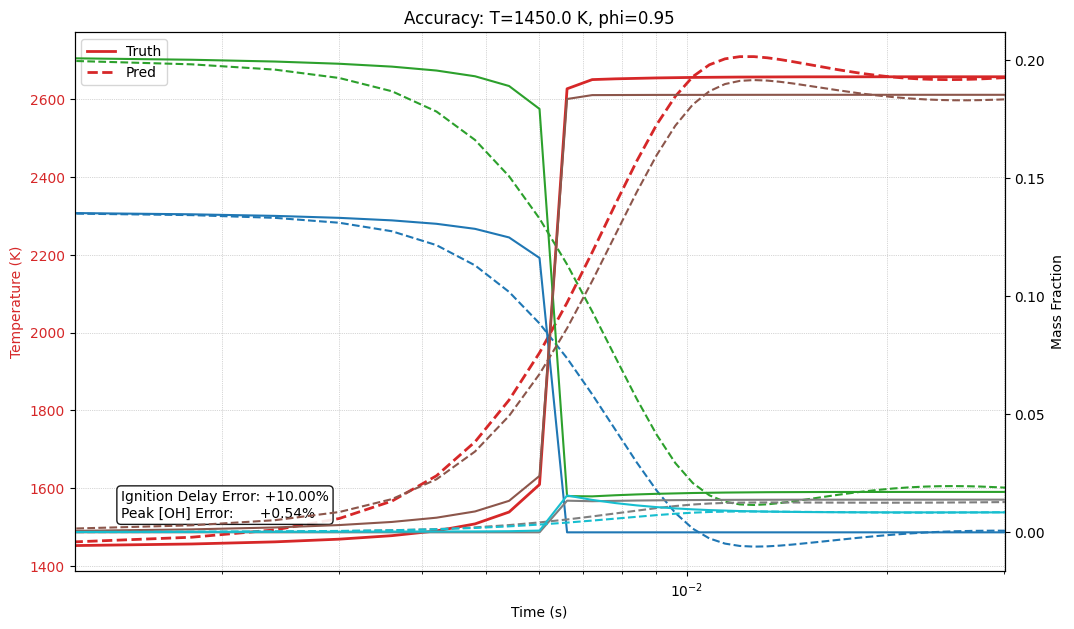

In [44]:
# Qualitative Accuracy Plots

def plot_comparison(df_truth, df_pred, T0, phi):
    fig, ax1 = plt.subplots(figsize=(12, 7))
    species_to_plot = ['NH3', 'O2', 'H2O', 'OH', 'NO']

    # Plot Temp
    color = 'tab:red'
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Temperature (K)', color=color)
    ax1.plot(df_truth['Time (s)'], df_truth['Temperature (K)'], color=color, label='Truth', lw=2)
    ax1.plot(df_pred['Time (s)'], df_pred['Temperature (K)'], color=color, linestyle='--', label='Pred', lw=2)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.grid(which='both', linestyle=':', linewidth=0.5)
    ax1.set_xscale('log')

    # Plot Species
    ax2 = ax1.twinx()
    ax2.set_ylabel('Mass Fraction')
    colors = plt.cm.get_cmap('tab10', len(species_to_plot))
    for i, sp in enumerate(species_to_plot):
        if sp in df_truth.columns:
            ax2.plot(df_truth['Time (s)'], df_truth[sp], color=colors(i), label=f'{sp} (Truth)', lw=1.5)
            ax2.plot(df_pred['Time (s)'], df_pred[sp], color=colors(i), linestyle='--', lw=1.5)

    ax1.legend(loc='upper left')
    plt.title(f'Accuracy: T={T0} K, phi={phi}')

    # Metrics
    tau_truth = calculate_ignition_delay(df_truth)
    tau_pred = calculate_ignition_delay(df_pred)

    if not np.isnan(tau_truth) and not np.isnan(tau_pred):
        err_tau = ((tau_pred - tau_truth)/tau_truth)*100
        # Zoom x-axis
        ax1.set_xlim(tau_truth * 0.2, tau_truth * 5)
    else:
        err_tau = np.nan

    oh_peak_err = ((df_pred['OH'].max() - df_truth['OH'].max()) / df_truth['OH'].max()) * 100

    # Text Box
    text_str = (f"Ignition Delay Error: {err_tau:+.2f}%\n"
                f"Peak [OH] Error:      {oh_peak_err:+.2f}%")
    ax1.text(0.05, 0.1, text_str, transform=ax1.transAxes,
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))

    plt.show()

print("--- Generating Plots ---")
for T0, phi in TEST_CASES:
    df_truth = get_ground_truth_sim(T0, phi, ct.one_atm)
    df_pred = get_node_prediction(T0, phi, ct.one_atm)
    plot_comparison(df_truth, df_pred, T0, phi)


--- Running Part D: Combined Temperature Comparison ---
Processing case: T=1250.0 K, phi=0.7


/tmp/ipython-input-3498158023.py:11: DeprecationWarning: ReactorBase.__init__: After Cantera 3.2, the default value of the `clone` argument will be `True`, resulting in an independent copy of the `phase` being created for use by this reactor. Add the `clone=False` argument to retain the old behavior of sharing `Solution` objects.
  r = ct.IdealGasConstPressureReactor(gas)


Processing case: T=1350.0 K, phi=1.2


/tmp/ipython-input-3498158023.py:11: DeprecationWarning: ReactorBase.__init__: After Cantera 3.2, the default value of the `clone` argument will be `True`, resulting in an independent copy of the `phase` being created for use by this reactor. Add the `clone=False` argument to retain the old behavior of sharing `Solution` objects.
  r = ct.IdealGasConstPressureReactor(gas)


Processing case: T=1450.0 K, phi=0.95


/tmp/ipython-input-3498158023.py:11: DeprecationWarning: ReactorBase.__init__: After Cantera 3.2, the default value of the `clone` argument will be `True`, resulting in an independent copy of the `phase` being created for use by this reactor. Add the `clone=False` argument to retain the old behavior of sharing `Solution` objects.
  r = ct.IdealGasConstPressureReactor(gas)


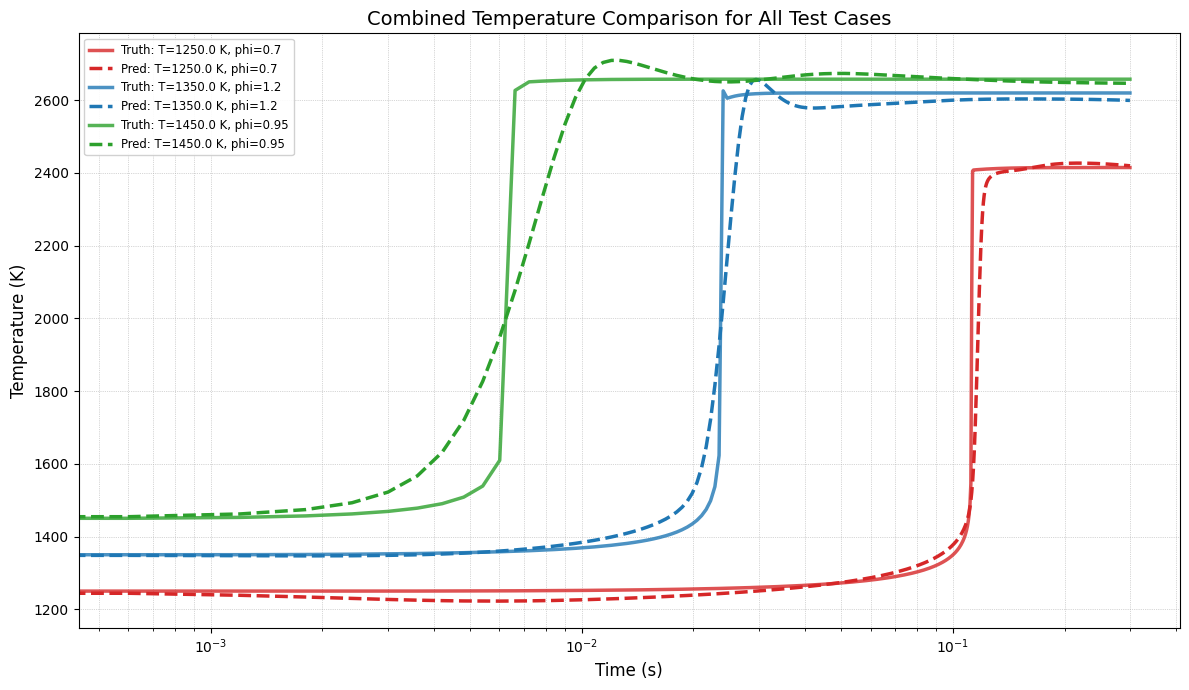

--- Combined plot complete ---


In [46]:
# --- Part D: Combined Temperature Comparison Plot ---

print("\n--- Running Part D: Combined Temperature Comparison ---")

fig, ax1 = plt.subplots(figsize=(12, 7))

# Use distinct colors (Red, Blue, Green) instead of a gradient
# This makes it much easier to see specific cases
custom_colors = ['tab:red', 'tab:blue', 'tab:green', 'tab:purple', 'tab:orange']

# Loop over all test cases
for i, (T0, phi) in enumerate(TEST_CASES):
    print(f"Processing case: T={T0} K, phi={phi}")

    # 1. Get Ground Truth
    df_truth = get_ground_truth_sim(T0, phi, ct.one_atm)

    # 2. Get NODE Prediction
    df_pred = get_node_prediction(T0, phi, ct.one_atm)

    # 3. Plot this case
    case_label = f"T={T0} K, phi={phi}"
    color = custom_colors[i % len(custom_colors)]

    # Plot Ground Truth (Solid Line)
    ax1.plot(df_truth['Time (s)'], df_truth['Temperature (K)'],
             color=color, linestyle='-', lw=2.5, alpha=0.8,
             label=f'Truth: {case_label}')

    # Plot Prediction (Dashed Line)
    ax1.plot(df_pred['Time (s)'], df_pred['Temperature (K)'],
             color=color, linestyle='--', lw=2.5,
             label=f'Pred: {case_label}')

# --- Finalize Plot ---
ax1.set_xlabel('Time (s)', fontsize=12)
ax1.set_ylabel('Temperature (K)', fontsize=12)
ax1.set_xscale('log')
ax1.grid(which='both', linestyle=':', linewidth=0.5)

# Place legend outside the plot area if it's too crowded, or 'best' inside
ax1.legend(loc='upper left', fontsize='small', framealpha=0.9)

plt.title('Combined Temperature Comparison for All Test Cases', fontsize=14)
plt.tight_layout()
plt.show()

print("--- Combined plot complete ---")


--- Running Part E: Combined OH Radical Comparison ---
Processing case: T=1250.0 K, phi=0.7


/tmp/ipython-input-3498158023.py:11: DeprecationWarning: ReactorBase.__init__: After Cantera 3.2, the default value of the `clone` argument will be `True`, resulting in an independent copy of the `phase` being created for use by this reactor. Add the `clone=False` argument to retain the old behavior of sharing `Solution` objects.
  r = ct.IdealGasConstPressureReactor(gas)


Processing case: T=1350.0 K, phi=1.2


/tmp/ipython-input-3498158023.py:11: DeprecationWarning: ReactorBase.__init__: After Cantera 3.2, the default value of the `clone` argument will be `True`, resulting in an independent copy of the `phase` being created for use by this reactor. Add the `clone=False` argument to retain the old behavior of sharing `Solution` objects.
  r = ct.IdealGasConstPressureReactor(gas)


Processing case: T=1450.0 K, phi=0.95


/tmp/ipython-input-3498158023.py:11: DeprecationWarning: ReactorBase.__init__: After Cantera 3.2, the default value of the `clone` argument will be `True`, resulting in an independent copy of the `phase` being created for use by this reactor. Add the `clone=False` argument to retain the old behavior of sharing `Solution` objects.
  r = ct.IdealGasConstPressureReactor(gas)


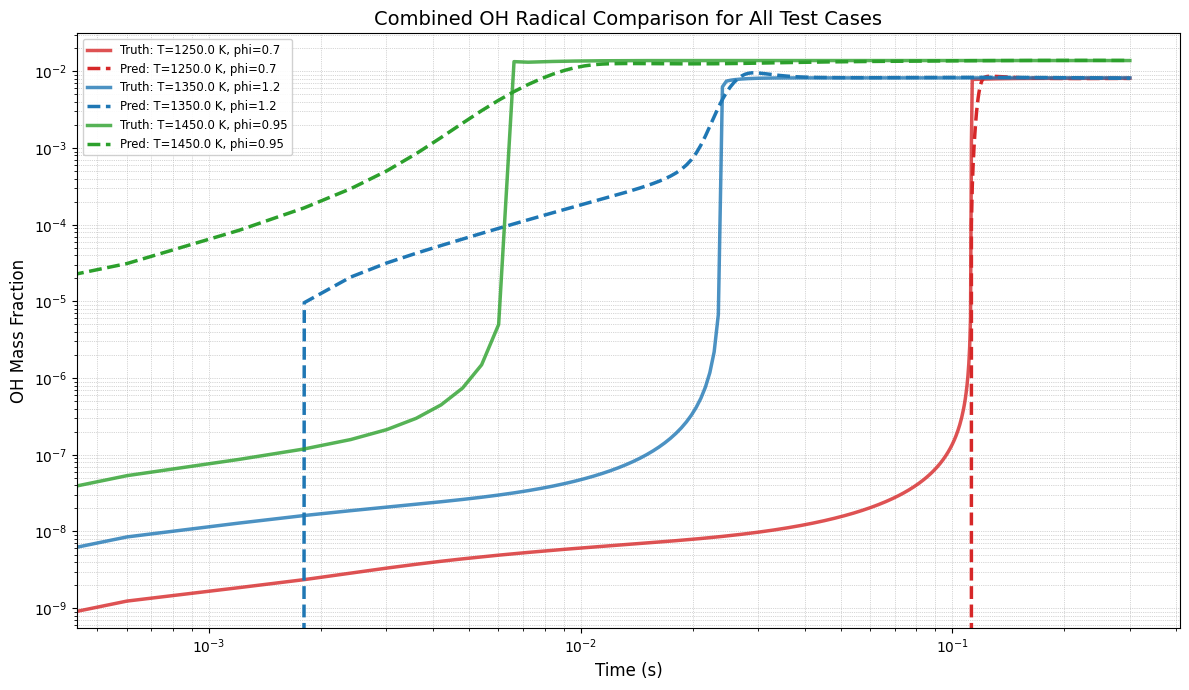

--- Combined OH plot complete ---


In [47]:
# --- Part E: Combined OH Radical Comparison Plot ---

print("\n--- Running Part E: Combined OH Radical Comparison ---")

fig, ax1 = plt.subplots(figsize=(12, 7))

# Use the same distinct colors for consistency
custom_colors = ['tab:red', 'tab:blue', 'tab:green', 'tab:purple', 'tab:orange']

# Loop over all test cases
for i, (T0, phi) in enumerate(TEST_CASES):
    print(f"Processing case: T={T0} K, phi={phi}")

    # 1. Get Ground Truth
    df_truth = get_ground_truth_sim(T0, phi, ct.one_atm)

    # 2. Get NODE Prediction
    df_pred = get_node_prediction(T0, phi, ct.one_atm)

    # 3. Plot this case's OH curves
    case_label = f"T={T0} K, phi={phi}"
    color = custom_colors[i % len(custom_colors)]

    # Plot Ground Truth (Solid Line)
    ax1.plot(df_truth['Time (s)'], df_truth['OH'],
             color=color, linestyle='-', lw=2.5, alpha=0.8,
             label=f'Truth: {case_label}')

    # Plot Prediction (Dashed Line)
    ax1.plot(df_pred['Time (s)'], df_pred['OH'],
             color=color, linestyle='--', lw=2.5,
             label=f'Pred: {case_label}')

# --- Finalize Plot ---
ax1.set_xlabel('Time (s)', fontsize=12)
ax1.set_ylabel('OH Mass Fraction', fontsize=12)
ax1.set_xscale('log')
ax1.set_yscale('log')  # Log-Log is best for radicals
ax1.grid(which='both', linestyle=':', linewidth=0.5)

# Set Y-axis limit to avoid log(0) issues at the very start if needed
# ax1.set_ylim(bottom=1e-10)

ax1.legend(loc='upper left', fontsize='small', framealpha=0.9)

plt.title('Combined OH Radical Comparison for All Test Cases', fontsize=14)
plt.tight_layout()
plt.show()

print("--- Combined OH plot complete ---")

In [48]:
# Quantitative Table

results = []
for T0, phi in TEST_CASES:
    df_truth = get_ground_truth_sim(T0, phi, ct.one_atm)
    df_pred = get_node_prediction(T0, phi, ct.one_atm)

    tau_t = calculate_ignition_delay(df_truth)
    tau_p = calculate_ignition_delay(df_pred)

    err_tau = ((tau_p - tau_t)/tau_t)*100 if not np.isnan(tau_t) else np.nan
    err_oh = ((df_pred['OH'].max() - df_truth['OH'].max()) / df_truth['OH'].max()) * 100

    results.append({
        "Case": f"T={T0}, phi={phi}",
        "Tau Truth (ms)": tau_t*1000,
        "Tau Pred (ms)": tau_p*1000,
        "Tau Error (%)": err_tau,
        "OH Peak Error (%)": err_oh
    })

print(pd.DataFrame(results).to_string(float_format="%.2f"))

/tmp/ipython-input-3498158023.py:11: DeprecationWarning: ReactorBase.__init__: After Cantera 3.2, the default value of the `clone` argument will be `True`, resulting in an independent copy of the `phase` being created for use by this reactor. Add the `clone=False` argument to retain the old behavior of sharing `Solution` objects.
  r = ct.IdealGasConstPressureReactor(gas)
/tmp/ipython-input-3498158023.py:11: DeprecationWarning: ReactorBase.__init__: After Cantera 3.2, the default value of the `clone` argument will be `True`, resulting in an independent copy of the `phase` being created for use by this reactor. Add the `clone=False` argument to retain the old behavior of sharing `Solution` objects.
  r = ct.IdealGasConstPressureReactor(gas)
/tmp/ipython-input-3498158023.py:11: DeprecationWarning: ReactorBase.__init__: After Cantera 3.2, the default value of the `clone` argument will be `True`, resulting in an independent copy of the `phase` being created for use by this reactor. Add the

                 Case  Tau Truth (ms)  Tau Pred (ms)  Tau Error (%)  OH Peak Error (%)
0   T=1250.0, phi=0.7          112.42         116.63           3.74               6.43
1   T=1350.0, phi=1.2           23.45          24.05           2.56              16.41
2  T=1450.0, phi=0.95            6.01           6.61          10.00               0.54


In [50]:
# Speed Test (JIT + Massive Batch)

N_BATCH = 2000 # Massive batch to saturate GPU
print(f"Benchmarking with {N_BATCH} simultaneous simulations...")

# 1. Prepare Batch Data (CPU)
np.random.seed(42)
Ts = np.random.uniform(1100, 1400, N_BATCH)
Phis = np.random.uniform(0.7, 1.3, N_BATCH)

batch_list = []
for i in range(N_BATCH):
    gas = ct.Solution(MECHANISM_FILE)
    gas.TP = Ts[i], ct.one_atm
    gas.set_equivalence_ratio(Phis[i], 'NH3', {'O2': 1.0, 'N2': 3.76})
    y_phy = np.array([gas.Y[gas.species_index(c)] if c!='Temperature (K)' else gas.T for c in feature_names])
    batch_list.append(normalize(y_phy))

y0_tensor = torch.tensor(np.array(batch_list), dtype=torch.float32).to(device)

# 2. Benchmark JIT NODE
DT = 5e-5
T_END = SIM_END_TIME

# Warmup
with torch.no_grad():
    jit_net.integrate(y0_tensor[:10], T_END, DT)
torch.cuda.synchronize()

# Run
start = time.time()
with torch.no_grad():
    # Call the integrated solver
    jit_net.integrate(y0_tensor, T_END, DT)
torch.cuda.synchronize()
node_time = (time.time() - start) / N_BATCH

# 3. Benchmark Cantera (Sample)
N_SAMPLE = 20
start = time.time()
for i in range(N_SAMPLE):
    get_ground_truth_sim(Ts[i], Phis[i], ct.one_atm)
cantera_time = (time.time() - start) / N_SAMPLE

print(f"\nCantera Time: {cantera_time*1000:.2f} ms")
print(f"NODE Time:    {node_time*1000:.2f} ms")
print(f"Speed-up:     {cantera_time/node_time:.2f}x")

Benchmarking with 2000 simultaneous simulations...


/tmp/ipython-input-3498158023.py:11: DeprecationWarning: ReactorBase.__init__: After Cantera 3.2, the default value of the `clone` argument will be `True`, resulting in an independent copy of the `phase` being created for use by this reactor. Add the `clone=False` argument to retain the old behavior of sharing `Solution` objects.
  r = ct.IdealGasConstPressureReactor(gas)
/tmp/ipython-input-3498158023.py:11: DeprecationWarning: ReactorBase.__init__: After Cantera 3.2, the default value of the `clone` argument will be `True`, resulting in an independent copy of the `phase` being created for use by this reactor. Add the `clone=False` argument to retain the old behavior of sharing `Solution` objects.
  r = ct.IdealGasConstPressureReactor(gas)
/tmp/ipython-input-3498158023.py:11: DeprecationWarning: ReactorBase.__init__: After Cantera 3.2, the default value of the `clone` argument will be `True`, resulting in an independent copy of the `phase` being created for use by this reactor. Add the


Cantera Time: 97.80 ms
NODE Time:    1.14 ms
Speed-up:     85.69x


/tmp/ipython-input-3498158023.py:11: DeprecationWarning: ReactorBase.__init__: After Cantera 3.2, the default value of the `clone` argument will be `True`, resulting in an independent copy of the `phase` being created for use by this reactor. Add the `clone=False` argument to retain the old behavior of sharing `Solution` objects.
  r = ct.IdealGasConstPressureReactor(gas)


In [ ]:
# -----------------------------------------------------------------
# Project Complete!
# -----------------------------------------------------------------